统计分析, all use swarm A(, all choose b_E,E_north?)

# 导入

In [1]:
import os.path
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import spectrogram
from utils import (
    OutlierData,
    interpolate_missing,
    align_high2low,
    get_3arrs,
)
from utils import get_nor_sou_split_indices_swarm_dmsp
from utils import histogram2d, coordinate
from utils import spectral
from utils import trace_dip, trace_auro_with_aacgmv2

import pyaw.satellite
import pyaw.utils
from src.pyaw import (
    PhysicalParameters,
    calculate_lower_bound,
    calculate_upper_bound,
    calculate_R,
    calculate_phase_vary_range,
)
from src.pyaw import plot_multi_panel, plot_gridded_panels

Load IGRF coefficients ...


# 基本变量设置

In [2]:
satellite = "SwarmA"
swarm_type = "A"

radius = 6816838.5 * 1e-3  # km
Re = 6371.2  # km
swarm_altitude = radius - Re  # km（初始高度）
auroral_altitude = 110  # km

data_dir_path_mag_hr = r"V:\aw\swarm\vires\measurements\SW_OPER_MAGA_HR_1B"
data_dir_path__mag_hr_igrf = r"V:\aw\swarm\vires\igrf\SW_OPER_MAGA_HR_1B"
data_dir_path_tct16 = r"V:\aw\swarm\vires\measurements\SW_EXPT_EFIA_TCT16"
data_dir_path_tct16_aux = r"V:\aw\swarm\vires\auxiliaries\SW_EXPT_EFIA_TCT16"

fs = 16
window = "hann"
spectrogram_window_seconds = 4

plt.style.use("seaborn-v0_8-paper")

cpsd_m_threshold = 0.3
num_bins = 50

mu0 = PhysicalParameters.mu0
Sigma_P_dy = 3.0
# Sigma_P_sta = 0.5
va_dy = 1.4e6
# va_sta = 1.3e6

boundary_l_dy = calculate_lower_bound(Sigma_P_dy)
boundary_h_dy = calculate_upper_bound(va_dy, Sigma_P_dy)
print(f"boundary_l_dy*mu0: {boundary_l_dy * mu0}")
print(f"boundary_h_dy*mu0: {boundary_h_dy * mu0}")

# boundary_l_sta = calculate_lower_bound(Sigma_P_sta)
# boundary_h_sta = calculate_upper_bound(va_sta, Sigma_P_sta)
print(f"boundary_l_dy*mu0: {boundary_l_dy * mu0}")
print(f"boundary_h_dy*mu0: {boundary_h_dy * mu0}")

reflection_coef_dy = calculate_R(v_A=va_dy, Sigma_P=Sigma_P_dy)
# reflection_coef_sta = calculate_R(v_A=va_sta, Sigma_P=Sigma_P_sta)

phase_vary_range_dy = calculate_phase_vary_range(reflection_coef_dy)
# phase_vary_range_sta = calculate_phase_vary_range(reflection_coef_sta)
print(f"phase_vary_range_dy: {phase_vary_range_dy}")
print(f"phase_vary_range_sta: {phase_vary_range_dy}")

boundary_l_dy*mu0: 0.3333333333333333
boundary_h_dy*mu0: 9.28532381410286
boundary_l_dy*mu0: 0.3333333333333333
boundary_h_dy*mu0: 9.28532381410286
phase_vary_range_dy: (68.54267010140487, -68.54267010140487)
phase_vary_range_sta: (68.54267010140487, -68.54267010140487)


# 基本函数

In [3]:
def parse_dt64(time):
    dt64 = datetime.fromisoformat(str(time))
    return dt64.strftime("%Y%m%dT%H%M%S")

# hemisphre

In [4]:
# done
# hemisphere = "N"

# done
hemisphere = "S"

# read and process data

In [5]:
# modify file_names
file_name_mag_hr = "SW_OPER_MAGA_HR_1B_12738_20160301T170459_20160301T183832.pkl"
file_name_mag_hr_igrf = "IGRF_SW_OPER_MAGA_HR_1B_12738_20160301T170459_20160301T183832.pkl"
file_name_tct16 = "SW_EXPT_EFIA_TCT16_12738_20160301T170459_20160301T183832.pkl"
file_name_tct16_aux = "aux_SW_EXPT_EFIA_TCT16_12738_20160301T170459_20160301T183832.pkl"

In [6]:
# get orbit number and orbit start time and time for the latter cases save to xlsx filename
base_name = os.path.splitext(file_name_mag_hr)[0]
parts = base_name.split('_')
file_orbit_number = parts[-3]
file_start_time = parts[-2]
file_end_time = parts[-1]

In [7]:
# file paths
file_path_mag_hr = os.path.join(data_dir_path_mag_hr, file_name_mag_hr)
file_path_mag_hr_igrf = os.path.join(data_dir_path__mag_hr_igrf, file_name_mag_hr_igrf)
file_path_tct16 = os.path.join(data_dir_path_tct16, file_name_tct16)
file_path_tct16_aux = os.path.join(data_dir_path_tct16_aux, file_name_tct16_aux)

In [8]:
# read data as df
df_b = pd.read_pickle(file_path_mag_hr)
df_b_igrf = pd.read_pickle(file_path_mag_hr_igrf)
df_e = pd.read_pickle(file_path_tct16)
df_e_aux = pd.read_pickle(file_path_tct16_aux)

# clip by 50 or -50 (depend on hemisphere)

In [9]:
# clip data from north and south and all abs greater than 50
lats_b = df_b["Latitude"].values
lats_e = df_e["Latitude"].values

indices_b = get_nor_sou_split_indices_swarm_dmsp(lats_b)
indices_e = get_nor_sou_split_indices_swarm_dmsp(lats_e)

assert hemisphere in ["N", "S"]
if hemisphere == "N":
    slice_b = slice(*indices_b[0])
    slice_e = slice(*indices_e[0])

else:
    slice_b = slice(*indices_b[1])
    slice_e = slice(*indices_e[1])

df_b = df_b.iloc[slice_b]
df_b_igrf = df_b_igrf.iloc[slice_b]
df_e = df_e.iloc[slice_e]
df_e_aux = df_e_aux.iloc[slice_e]

# nor_slice_b = slice(*indices_b[0])
# sou_slice_b = slice(*indices_b[1])
#
# nor_slice_e = slice(*indices_e[0])
# sou_slice_e = slice(*indices_e[1])

# get clip df by hemisphere
# df_b_nor = df_b.iloc[nor_slice_b]
# df_b_sou = df_b.iloc[sou_slice_b]
#
# df_b_igrf_nor = df_b_igrf.iloc[nor_slice_b]
# df_b_igrf_sou = df_b_igrf.iloc[sou_slice_b]
#
# df_e_nor = df_e.iloc[nor_slice_e]
# df_e_sou = df_e.iloc[sou_slice_e]
#
# df_e_aux_nor = df_e_aux.iloc[nor_slice_e]
# df_e_aux_sou = df_e_aux.iloc[sou_slice_e]

In [10]:
# get np.abs(lat)>50 clip df

latitude_threshold = 50
if hemisphere == "N":
    df_b = df_b[df_b['Latitude'] > latitude_threshold].copy()
    df_b_igrf = df_b_igrf[df_b_igrf['Latitude'] > latitude_threshold].copy()
    df_e = df_e[df_e['Latitude'] > latitude_threshold].copy()
    df_e_aux = df_e_aux[df_e_aux['Latitude'] > latitude_threshold].copy()
elif hemisphere == "S":
    df_b = df_b[df_b['Latitude'] < latitude_threshold].copy()
    df_b_igrf = df_b_igrf[df_b_igrf['Latitude'] < latitude_threshold].copy()
    df_e = df_e[df_e['Latitude'] < latitude_threshold].copy()
    df_e_aux = df_e_aux[df_e_aux['Latitude'] < latitude_threshold].copy()

# df_b_nor = df_b_nor[df_b_nor['Latitude'] > 50].copy()
# df_b_sou = df_b_sou[df_b_sou['Latitude'] < -50].copy()
#
# df_b_igrf_nor = df_b_igrf_nor[df_b_igrf_nor['Latitude'] > 50].copy()
# df_b_igrf_sou = df_b_igrf_sou[df_b_igrf_sou['Latitude'] < -50].copy()
#
# df_e_nor = df_e_nor[df_e_nor['Latitude'] > 50].copy()
# df_e_sou = df_e_sou[df_e_sou['Latitude'] < -50].copy()
#
# df_e_aux_nor = df_e_aux_nor[df_e_aux_nor['Latitude'] > 50].copy()
# df_e_aux_sou = df_e_aux_sou[df_e_aux_sou['Latitude'] < -50].copy()

# for robust
assert np.array_equal(df_b.index.values, df_b_igrf.index.values)
assert np.array_equal(df_e.index.values, df_e_aux.index.values)


# assert np.array_equal(df_b_nor.index.values, df_b_igrf_nor.index.values)
# assert np.array_equal(df_b_sou.index.values, df_b_igrf_sou.index.values)
#
# assert np.array_equal(df_e_nor.index.values, df_e_aux_nor.index.values)
# assert np.array_equal(df_e_sou.index.values, df_e_aux_sou.index.values)

# position info

In [11]:
latitudes = df_e["Latitude"].values
longitudes = df_e["Longitude"].values
qdlats = df_e_aux["QDLat"].values
mlts = df_e_aux["MLT"].values  # mlt

# process b,e

In [12]:
# process b

Ehx = df_e["Ehx"].values
Ehx_outlier = set_outliers_nan_std(Ehx, 1, print_=True)
Ehx_outlier_interp = interpolate_missing(Ehx_outlier, df_e.index.values)

Ehy = df_e["Ehy"].values
Ehy_outlier = set_outliers_nan_std(Ehy, 1, print_=True)
Ehy_outlier_interp = interpolate_missing(Ehy_outlier, df_e.index.values)

VsatN = df_e["VsatN"].values
VsatE = df_e["VsatE"].values

rotmat_nec2sc, rotmat_sc2nec = pyaw.satellite.NEC2SCandSC2NEC.get_rotmat_nec2sc_sc2nec(
    VsatN, VsatE
)
E_north, E_east = pyaw.satellite.NEC2SCandSC2NEC.do_rotation(
    -Ehx_outlier_interp, -Ehy_outlier_interp, rotmat_sc2nec
)

Outliers detected: 7288
Outlier values: [-91.42188  142.57861   57.543846 ... -32.566727 -30.981606 -36.31243 ]
Outliers detected: 8007
Outlier values: [160.89474   77.33726   45.17597  ...  81.699356  45.93756   46.79927 ]


In [13]:
# process b

B_N, B_E, _ = get_3arrs(df_b["B_NEC"].values)
B_N_IGRF, B_E_IGRF, _ = get_3arrs(df_b_igrf["B_NEC_IGRF"].values)
b_E = B_E - B_E_IGRF
b_N = B_N - B_N_IGRF

In [14]:
# align datetimes
datetimes_e = df_e.index.values
datetimes_b = df_b.index.values
b_E = align_high2low(b_E, datetimes_b, datetimes_e)
b_N = align_high2low(b_N, datetimes_b, datetimes_e)

# time info

In [15]:
# base datetimes
datetimes = datetimes_e
dt = datetime.fromisoformat(str(datetimes[0]))
start_time = dt.strftime("%Y%m%dT%H%M%S")
dt = datetime.fromisoformat(str(datetimes[-1]))
end_time = dt.strftime("%Y%m%dT%H%M%S")

# spectrogram

In [16]:
nperseg = int(spectrogram_window_seconds * fs)
frequencies, ts, Sxx_b = spectrogram(
    b_E,
    fs=fs,
    window=window,
    nperseg=nperseg,
    mode="complex",
)
_, _, Sxx_e = spectrogram(
    E_north, fs=fs, window=window, nperseg=nperseg, mode="complex"
)
ts_dt64 = datetimes[0] + [np.timedelta64(int(_), "s") for _ in ts]
cpsd = Sxx_e * np.conj(Sxx_b)

# coherency

In [17]:
segment_length_sec = 4  # 越大最后得到的数组的长度越小，取和之前的spectrogram输入的窗口长度是一个不错的选择
try:
    mid_times_all, avg_complex_coh = pyaw.utils.calculate_segmented_complex_coherency(
        datetimes,
        b_E,
        E_north,
        fs=fs,
        segment_length_sec=segment_length_sec,
        nfft_coh=int(
            fs * segment_length_sec * 0.5
        ),  # Use segment_length_sec/2 second FFT within segments
    )
    # Extract magnitude and phase from the complex result
    avg_coh_magnitude = np.abs(avg_complex_coh)

except ValueError as e:
    print(f"Error calculating Coherency: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# b plot: for latter static region set and dynamic region preset

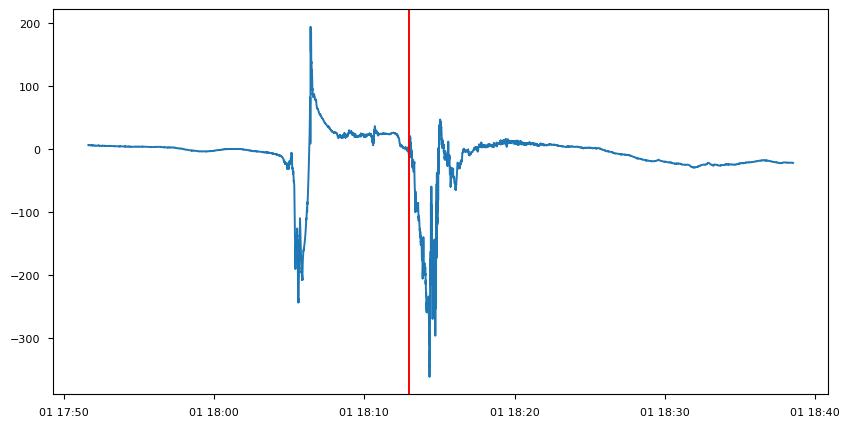

In [49]:
# b
figsize = (10, 5)
plt.figure(figsize=figsize)
plt.plot(datetimes, b_E)
vline_value = np.datetime64("2016-03-01 18:13:00")
plt.axvline(vline_value, color="red")
plt.show()

# pause for time info (cases), set static region and preset dynamic region

use the 1st plot to concise the region set

In [19]:
# initialize static region start time and end time base on the former b plot
st_sta = np.datetime64("2016-03-01 18:00:00")
et_sta = np.datetime64("2016-03-01 18:00:20")

# modify: cases dynamic region

In [20]:
# north
# renew save for potential rewrite exist file.
# save = False

# not
# st_dy = np.datetime64("2016-03-01 17:22:00")
# et_dy = np.datetime64("2016-03-01 17:22:20")

# not
# st_dy = np.datetime64("2016-03-01 17:22:20")
# et_dy = np.datetime64("2016-03-01 17:22:40")

# yes. ratio common low but reasonable, may because the boundary. phase diff good. trace success.
# st_dy = np.datetime64("2016-03-01 17:22:40")
# et_dy = np.datetime64("2016-03-01 17:23:00")

# same as before
# st_dy = np.datetime64("2016-03-01 17:23:00")
# et_dy = np.datetime64("2016-03-01 17:23:20")

# same as before, but trace fail.
# st_dy = np.datetime64("2016-03-01 17:23:20")
# et_dy = np.datetime64("2016-03-01 17:23:40")

# not
# st_dy = np.datetime64("2016-03-01 17:23:40")
# et_dy = np.datetime64("2016-03-01 17:24:00")

# not
# st_dy = np.datetime64("2016-03-01 17:24:00")
# et_dy = np.datetime64("2016-03-01 17:24:20")

# not
# st_dy = np.datetime64("2016-03-01 17:24:20")
# et_dy = np.datetime64("2016-03-01 17:24:40")

# not
# st_dy = np.datetime64("2016-03-01 17:31:00")
# et_dy = np.datetime64("2016-03-01 17:31:20")

# not
# st_dy = np.datetime64("2016-03-01 17:31:20")
# et_dy = np.datetime64("2016-03-01 17:31:40")

# not
# st_dy = np.datetime64("2016-03-01 17:31:40")
# et_dy = np.datetime64("2016-03-01 17:32:00")

# not
# st_dy = np.datetime64("2016-03-01 17:32:00")
# et_dy = np.datetime64("2016-03-01 17:32:20")

# not
# st_dy = np.datetime64("2016-03-01 17:32:20")
# et_dy = np.datetime64("2016-03-01 17:32:40")

# not
# st_dy = np.datetime64("2016-03-01 17:32:40")
# et_dy = np.datetime64("2016-03-01 17:33:00")

# not
# st_dy = np.datetime64("2016-03-01 17:33:00")
# et_dy = np.datetime64("2016-03-01 17:33:20")

# not
# st_dy = np.datetime64("2016-03-01 17:33:20")
# et_dy = np.datetime64("2016-03-01 17:33:40")

# yes. ratio after 4 bad. phase diff good. trace success.
# st_dy = np.datetime64("2016-03-01 17:33:40")
# et_dy = np.datetime64("2016-03-01 17:34:00")

# not
# st_dy = np.datetime64("2016-03-01 17:34:00")
# et_dy = np.datetime64("2016-03-01 17:34:20")

# not
# st_dy = np.datetime64("2016-03-01 17:34:20")
# et_dy = np.datetime64("2016-03-01 17:34:40")

In [77]:
# south
# renew save for potential rewrite exist file.
save = False

# not
# st_dy = np.datetime64("2016-03-01 18:05:00")
# et_dy = np.datetime64("2016-03-01 18:05:20")

# not
# st_dy = np.datetime64("2016-03-01 18:05:20")
# et_dy = np.datetime64("2016-03-01 18:05:40")

# not
# st_dy = np.datetime64("2016-03-01 18:05:40")
# et_dy = np.datetime64("2016-03-01 18:06:00")

# not
# st_dy = np.datetime64("2016-03-01 18:06:00")
# et_dy = np.datetime64("2016-03-01 18:06:20")

# yes (and good). trace success.
# st_dy = np.datetime64("2016-03-01 18:06:20")
# et_dy = np.datetime64("2016-03-01 18:06:40")

# not
# st_dy = np.datetime64("2016-03-01 18:06:40")
# et_dy = np.datetime64("2016-03-01 18:07:00")

# not
# st_dy = np.datetime64("2016-03-01 18:07:00")
# et_dy = np.datetime64("2016-03-01 18:07:20")

# not
# st_dy = np.datetime64("2016-03-01 18:13:00")
# et_dy = np.datetime64("2016-03-01 18:13:20")

# not
# st_dy = np.datetime64("2016-03-01 18:13:20")
# et_dy = np.datetime64("2016-03-01 18:13:40")

# not
# st_dy = np.datetime64("2016-03-01 18:13:40")
# et_dy = np.datetime64("2016-03-01 18:14:00")

# not. bad electric field data.
# st_dy = np.datetime64("2016-03-01 18:14:00")
# et_dy = np.datetime64("2016-03-01 18:14:20")

# not
# st_dy = np.datetime64("2016-03-01 18:14:20")
# et_dy = np.datetime64("2016-03-01 18:14:40")

# not
# st_dy = np.datetime64("2016-03-01 18:15:00")
# et_dy = np.datetime64("2016-03-01 18:15:20")

# not
# st_dy = np.datetime64("2016-03-01 18:15:20")
# et_dy = np.datetime64("2016-03-01 18:15:40")

# not
# st_dy = np.datetime64("2016-03-01 18:15:40")
# et_dy = np.datetime64("2016-03-01 18:16:00")

# not
st_dy = np.datetime64("2016-03-01 18:16:00")
et_dy = np.datetime64("2016-03-01 18:16:20")

# 1st plot

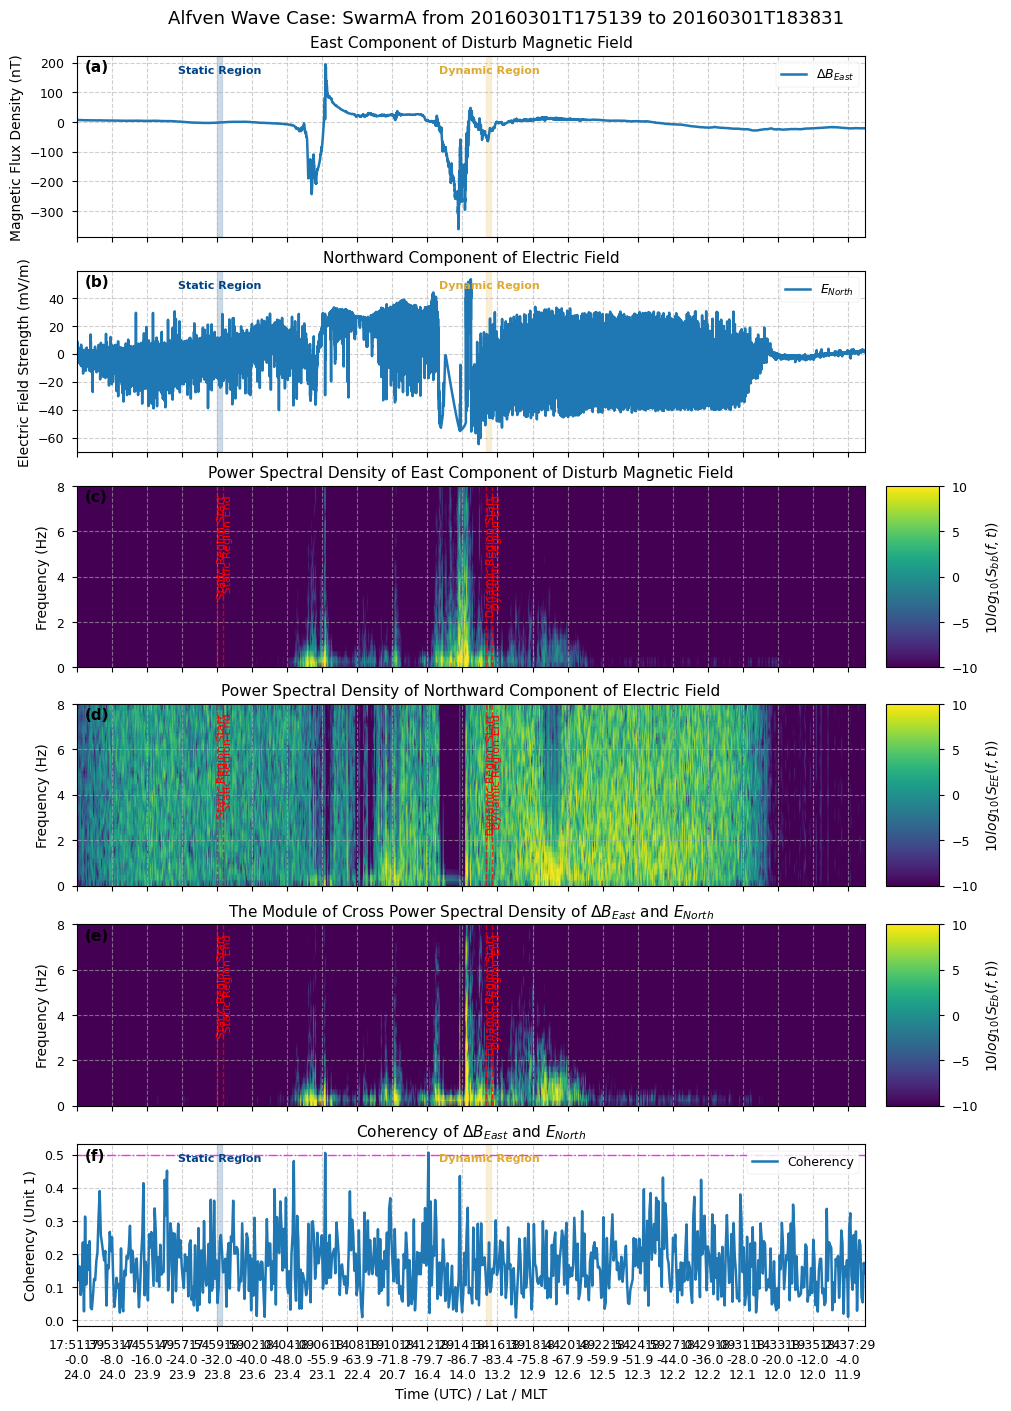

In [78]:
subplot_defs = [
    {
        "plot_type": "line",
        "x_data": datetimes,
        "y_data": b_E,
        "label": r"$\Delta B_{East}$",
        "title": "East Component of Disturb Magnetic Field",
        "ylabel": "Magnetic Flux Density (nT)",
        "linewidth": 1.8,
    },  # Slightly thicker line
    {
        "plot_type": "line",
        "x_data": datetimes,  # Assuming same time base for E-field line plot
        "y_data": E_north,
        "label": r"$E_{North}$",
        "title": "Northward Component of Electric Field",
        "ylabel": "Electric Field Strength (mV/m)",
        "linewidth": 1.8,
    },
    {
        "plot_type": "pcolormesh",
        "x_data": ts_dt64,
        "y_data": frequencies,
        "z_data": 10 * np.log10(np.abs(Sxx_b)),
        "title": "Power Spectral Density of East Component of Disturb Magnetic Field",
        "ylabel": "Frequency (Hz)",
        "clabel": r"$10log_{10}(S_{bb}(f,t))$",
        "shading": "gouraud",
        # "vmin": -10,
        # "vmax": 10,
        # 'cmap': 'plasma' # Example local override
    },
    {
        "plot_type": "pcolormesh",
        "x_data": ts_dt64,
        "y_data": frequencies,
        "z_data": 10 * np.log10(np.abs(Sxx_e)),
        "title": "Power Spectral Density of Northward Component of Electric Field",
        "ylabel": "Frequency (Hz)",
        "clabel": r"$10log_{10}(S_{EE}(f,t))$",
        "shading": "gouraud",
        # "vmin": -10,
        # "vmax": 10,
    },
    {
        "plot_type": "pcolormesh",
        "x_data": ts_dt64,
        "y_data": frequencies,
        "z_data": 10 * np.log10(np.abs(cpsd)),
        "title": r"The Module of Cross Power Spectral Density of $\Delta B_{East}$ and $E_{North}$",
        "ylabel": "Frequency (Hz)",
        "clabel": r"$10log_{10}(S_{Eb}(f,t))$",
        "shading": "gouraud",
        # "vmin": -10,
        # "vmax": 10,
        # 'vmin': -50 # Example local override for clim
    },
    {
        "plot_type": "line",
        "x_data": mid_times_all,
        "y_data": avg_coh_magnitude,
        "label": r"Coherency",
        "title": "Coherency of $\Delta B_{East}$ and $E_{North}$",
        "ylabel": "Coherency (Unit 1)",
        "linewidth": 1.8,
    },
]

# add labels, annotations ...

for subplot_def in subplot_defs[:2]:
    subplot_def["blocks"] = [
        {
            "start": st_sta,
            "end": et_sta,
            "color": "#004488",
            "label": "Static Region",
        },
        {
            "start": st_dy,
            "end": et_dy,
            "color": "#DDAA33",
            "label": "Dynamic Region",
        },
    ]
for subplot_def in subplot_defs[2:-1]:
    subplot_def["vlines"] = {
        "Static Region Start": st_sta,
        "Static Region End": et_sta,
        "Dynamic Region Start": st_dy,
        "Dynamic Region End": et_dy,
    }
subplot_defs[-1]["blocks"] = [
    {
        "start": st_sta,
        "end": et_sta,
        "color": "#004488",
        "label": "Static Region",
    },
    {
        "start": st_dy,
        "end": et_dy,
        "color": "#DDAA33",
        "label": "Dynamic Region",
    },
]
subplot_defs[-1]["hlines"] = [{"y": 0.5, "color": "magenta", "linestyle": "-."}]

# Define Aux Data for X labels
aux_data_for_x = {"Lat": latitudes, "MLT": mlts}

# Call the function to plot
x_label_step = 2000
fig1, axes1 = plot_multi_panel(
    subplot_definitions=subplot_defs,
    x_datetime_ref=datetimes,  # Reference times for aux data (note that lats,mlts based on datetimes not tsdt64)
    x_aux_data=aux_data_for_x,  # The aux data arrays
    x_label_step=x_label_step,  # Show label every N points
    figsize=(10, 14),
    figure_title=f"Alfven Wave Case: Swarm{swarm_type} from {start_time} to {end_time}",
    # global_cmap=matplotlib.rcParams["image.cmap"],  # default
    global_cmap="viridis",
    global_vmin=-10,  # Example: Manually set global limits
    global_vmax=10,
    use_shared_clims=True,  # Use calculated shared limits unless overridden
    rotate_xticklabels=0,  # Keep horizontal for concise formatter
    # font size
    title_fontsize=11,
    label_fontsize=10,
    tick_label_fontsize=9,
    legend_fontsize=9,
    annotation_fontsize=8,
    panel_label_fontsize=11,  # Control (a), (b)... size
)
plt.show()

# 2nd plot

Calculating shared color limits...
 Calculated shared vmin=0.00, vmax=0.00 (raw data)


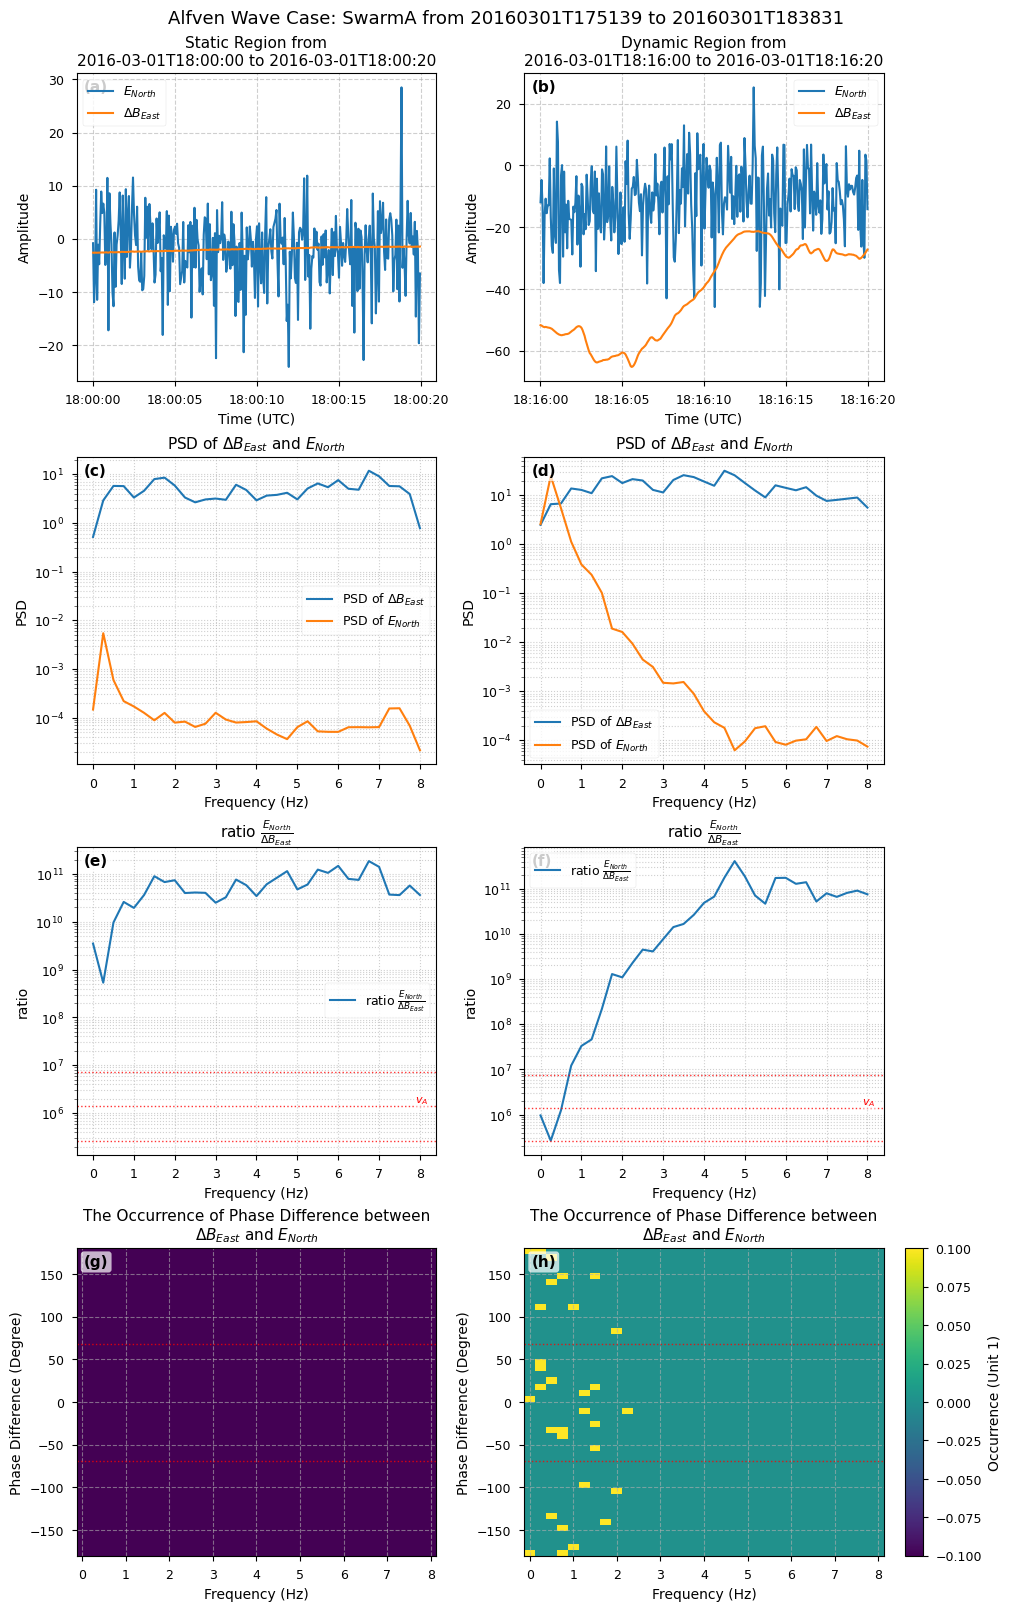

In [79]:
# dy
t_mask_dy = (datetimes >= st_dy) & (datetimes <= et_dy)
datetimes_dy = datetimes[t_mask_dy]
b_E_dy = b_E[t_mask_dy]
E_north_dy = E_north[t_mask_dy]

# sta
t_mask_sta = (datetimes >= st_sta) & (datetimes <= et_sta)
datetimes_sta = datetimes[t_mask_sta]
b_E_sta = b_E[t_mask_sta]
E_north_sta = E_north[t_mask_sta]

# psd
nperseg_sec = spectrogram_window_seconds
nperseg_psd = int(nperseg_sec * fs)  # same as the 1st spectrogram nperseg

delta_B_E_align_dy_psd = pyaw.utils.CustomizedWelch(
    b_E_dy,
    fs=fs,
    nperseg=nperseg_psd,
    window=window,
    scaling="density",
)  # same arguments setting as spectrogram
E_north_dy_psd = pyaw.utils.CustomizedWelch(
    E_north_dy,
    fs=fs,
    nperseg=nperseg_psd,
    window=window,
    scaling="density",
)
delta_B_E_align_sta_psd = pyaw.utils.CustomizedWelch(
    b_E_sta,
    fs=fs,
    nperseg=nperseg_psd,
    window=window,
    scaling="density",
)
E_north_sta_psd = pyaw.utils.CustomizedWelch(
    E_north_sta,
    fs=fs,
    nperseg=nperseg_psd,
    window=window,
    scaling="density",
)

frequencies_psd_dy, Pxx_delta_B_E_align_dy = delta_B_E_align_dy_psd.get_psd()
_, Pxx_E_north_dy = E_north_dy_psd.get_psd()
frequencies_psd_sta, Pxx_delta_B_E_align_sta = delta_B_E_align_sta_psd.get_psd()
_, Pxx_E_north_sta = E_north_sta_psd.get_psd()

# cpsd for phase difference
spectrogram_window_seconds_region = 4  # compare to the former spectrogram 4
nperseg = int(spectrogram_window_seconds_region * fs)

frequencies_spec_dy, ts_dy, Sxx_b_dy = spectrogram(
    b_E_dy,
    fs=fs,
    window=window,
    nperseg=nperseg,
    mode="complex",
)

_, _, Sxx_e_dy = spectrogram(
    E_north_dy, fs=fs, window=window, nperseg=nperseg, mode="complex"
)

frequencies_spec_sta, ts_sta, Sxx_b_sta = spectrogram(
    b_E_sta,
    fs=fs,
    window=window,
    nperseg=nperseg,
    mode="complex",
)
_, _, Sxx_e_sta = spectrogram(
    E_north_sta,
    fs=fs,
    window=window,
    nperseg=nperseg,
    mode="complex",
)

ts_dt64_dy = datetimes_dy[0] + [np.timedelta64(int(_), "s") for _ in ts_dy]
ts_dt64_sta = datetimes_sta[0] + [np.timedelta64(int(_), "s") for _ in ts_sta]

cpsd_dy = Sxx_e_dy * np.conj(Sxx_b_dy)
cpsd_sta = Sxx_e_sta * np.conj(Sxx_b_sta)

cpsd_phase_dy = np.degrees(np.angle(cpsd_dy))
cpsd_m_dy = np.abs(cpsd_dy)
cpsd_phase_dy[cpsd_m_dy < cpsd_m_threshold] = np.nan  # threshold
phase_bins_dy, phase_histogram2d_dy = pyaw.utils.get_phase_histogram2d(
    frequencies_spec_dy, cpsd_phase_dy, num_bins=num_bins
)

cpsd_phase_sta = np.degrees(np.angle(cpsd_sta))
cpsd_m_sta = np.abs(cpsd_sta)
cpsd_phase_sta[cpsd_m_sta < cpsd_m_threshold] = np.nan  # threshold
phase_bins_sta, phase_histogram2d_sta = pyaw.utils.get_phase_histogram2d(
    frequencies_spec_sta, cpsd_phase_sta, num_bins=num_bins
)

# ratio
eb_ratio_psd_dy = (
        (Pxx_E_north_dy / Pxx_delta_B_E_align_dy) * 1e-3 * 1e9
)  # transform unit
eb_ratio_psd_sta = (Pxx_E_north_sta / Pxx_delta_B_E_align_sta) * 1e-3 * 1e9

# plot
nrows, ncols_main = 4, 2
plot_defs = [[None for _ in range(ncols_main)] for _ in range(nrows)]
# Row 0
plot_defs[0][0] = {
    "plot_type": "line",
    "x_data": datetimes_sta,
    "y_data_list": [
        E_north_sta,
        b_E_sta,
    ],  # 先用蓝色绘制电场，在用橙色绘制磁场
    "linewidth": 1.8,
    "labels": [r"$E_{North}$", r"$\Delta {B_{East}}$"],
    "title": f"Static Region from\n{st_sta} to {et_sta}",
    "xlabel": "Time (UTC)",
    "ylabel": "Amplitude",
}
plot_defs[0][1] = {
    "plot_type": "line",
    "x_data": datetimes_dy,
    "y_data_list": [E_north_dy, b_E_dy],
    "labels": [r"$E_{North}$", r"$\Delta {B_{East}}$"],
    "title": f"Dynamic Region from\n{st_dy} to {et_dy}",
    "xlabel": "Time (UTC)",
    "ylabel": "Amplitude",
}
# Row 1
plot_defs[1][0] = {
    "plot_type": "line",
    "x_data": frequencies_psd_sta,
    "y_data_list": [Pxx_E_north_sta, Pxx_delta_B_E_align_sta],
    "labels": [r"PSD of $\Delta {B_{East}}$", r"PSD of $E_{North}$"],
    "yscale": "log",  # Use log scale
    "title": "PSD of $\Delta {B_{East}}$ and $E_{North}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "PSD",
}
plot_defs[1][1] = {
    "plot_type": "line",
    "x_data": frequencies_psd_dy,
    "y_data_list": [Pxx_E_north_dy, Pxx_delta_B_E_align_dy],
    "labels": [r"PSD of $\Delta {B_{East}}$", r"PSD of $E_{North}$"],
    "yscale": "log",  # Use log scale
    "title": "PSD of $\Delta {B_{East}}$ and $E_{North}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "PSD",
}
# Row 2
plot_defs[2][0] = {
    "plot_type": "line",
    "x_data": frequencies_psd_sta,
    "y_data_list": [eb_ratio_psd_sta],
    "yscale": "log",  # Use log scale
    "labels": [r"ratio $\frac{E_{North}}{\Delta {B_{East}}}$"],
    "title": r"ratio $\frac{E_{North}}{\Delta {B_{East}}}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "ratio",
    "hlines": [
        {"y": boundary_l_dy},
        {
            "y": boundary_h_dy,
        },
        {"y": va_dy, "label": r"$v_A$"},
    ],
}
plot_defs[2][1] = {
    "plot_type": "line",
    "x_data": frequencies_psd_dy,
    "y_data_list": [eb_ratio_psd_dy],
    "yscale": "log",
    "labels": [r"ratio $\frac{E_{North}}{\Delta {B_{East}}}$"],
    "title": r"ratio $\frac{E_{North}}{\Delta {B_{East}}}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "ratio",
    "hlines": [
        {"y": boundary_l_dy},
        {
            "y": boundary_h_dy,
        },
        {"y": va_dy, "label": r"$v_A$"},
    ],
}  # Normal line plot here
# Row 3
plot_defs[3][0] = {
    "plot_type": "pcolormesh",
    "x_data": frequencies_spec_sta,
    "y_data": (phase_bins_sta[:-1] + phase_bins_sta[1:]) / 2,
    "z_data": phase_histogram2d_sta.T,
    "title": "The Occurrence of Phase Difference between\n$\Delta {B_{East}}$ and $E_{North}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "Phase Difference (Degree)",
    "shading": "auto",
    "hlines": [{"y": phase_vary_range_dy[0]}, {"y": phase_vary_range_dy[1]}],
}
plot_defs[3][1] = {
    "plot_type": "pcolormesh",
    "x_data": frequencies_spec_dy,
    "y_data": (phase_bins_dy[:-1] + phase_bins_dy[1:]) / 2,
    "z_data": phase_histogram2d_dy.T,
    "title": "The Occurrence of Phase Difference between\n$\Delta {B_{East}}$ and $E_{North}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "Phase Difference (Degree)",
    "shading": "auto",
    "hlines": [{"y": phase_vary_range_dy[0]}, {"y": phase_vary_range_dy[1]}],
}

fig2, axes2 = plot_gridded_panels(
    plot_definitions=plot_defs,
    nrows=4,
    ncols_main=2,
    add_shared_cbar=True,
    shared_cbar_label="Occurrence (Unit 1)",
    figure_title=f"Alfven Wave Case: Swarm{swarm_type} from {start_time} to {end_time}",
    figsize=(10, 16),  # Adjust size
    use_shared_clims=True,  # Use shared clim for spectrograms
    title_fontsize=11,
    label_fontsize=10,
    tick_label_fontsize=9,
    legend_fontsize=9,
    annotation_fontsize=8,
    panel_label_fontsize=11,
)
plt.show()

# save or not!!!

In [36]:
save = True

In [37]:
if save:
    # basic data
    latitudes_dy = latitudes[t_mask_dy]
    start_lat_dy = latitudes_dy[0]
    end_lat_dy = latitudes_dy[-1]

    longitudes_dy = longitudes[t_mask_dy]
    start_lon_dy = longitudes_dy[0]
    end_lon_dy = longitudes_dy[-1]

    qdlats_dy = qdlats[t_mask_dy]
    start_qdlats_dy = qdlats_dy[0]
    end_qdlats_dy = qdlats_dy[-1]

    mlts_dy = mlts[t_mask_dy]
    start_mlts_dy = mlts_dy[0]
    end_mlts_dy = mlts_dy[-1]

    # get dip and auro data
    trace_set_rlim = 9999  # 果然geopack最多就到999个地球半径
    trace_set_maxloop = 100000
    # st
    # trace dip
    start_dip_loop_num, start_dip_trace_max_R, start_dip_alt, start_dip_lat, start_dip_lon, start_trace_alts, start_trace_lats, start_trace_lons = trace_dip(
        time=st_dy,
        alt0=swarm_altitude,
        lat0=start_lat_dy,
        lon0=start_lon_dy,
        _hemisphere=hemisphere,
        trace_set_rlim=trace_set_rlim,
        trace_set_maxloop=trace_set_maxloop)
    # trace auroral altitude use aacgmv2
    start_auro_lat_aacgmv2, start_auro_lon_aacgmv2 = trace_auro_with_aacgmv2(lat0=start_lat_dy, lon0=start_lon_dy,
                                                                             alt0=swarm_altitude,
                                                                             date=st_dy.astype('datetime64[D]').item(),
                                                                             auroral_altitude=auroral_altitude)
    # et
    # trace dip
    end_dip_loop_num, end_dip_trace_max_R, end_dip_alt, end_dip_lat, end_dip_lon, end_trace_alts, end_trace_lats, end_trace_lons = trace_dip(
        time=et_dy,
        alt0=swarm_altitude,
        lat0=end_lat_dy,
        lon0=end_lon_dy,
        _hemisphere=hemisphere,
        trace_set_rlim=trace_set_rlim,
        trace_set_maxloop=trace_set_maxloop)
    # trace auroral altitude use aacgmv2
    end_auro_lat_aacgmv2, end_auro_lon_aacgmv2 = trace_auro_with_aacgmv2(lat0=end_lat_dy, lon0=end_lon_dy,
                                                                         alt0=swarm_altitude,
                                                                         date=et_dy.astype('datetime64[D]').item(),
                                                                         auroral_altitude=auroral_altitude)

    # 初始化字典
    cases_dic = {}
    # 单个事件的关键数据组成的字典
    case_data = {
        "satellite": satellite,
        "orbit_number": file_orbit_number,
        "alt0": swarm_altitude,
        "hemisphere": hemisphere,
        "auro_altitude": auroral_altitude,
        "start_time": st_dy,
        "start_latitude": start_lat_dy,
        "start_longitude": start_lon_dy,
        "start_dip_loop_num": start_dip_loop_num,
        "start_dip_trace_max_R": start_dip_trace_max_R,
        "start_dip_alt": start_dip_alt,
        "start_dip_lat": start_dip_lat,
        "start_dip_lon": start_dip_lon,
        "start_auro_lat_aacgmv2": start_auro_lat_aacgmv2,
        "start_auro_lon_aacgmv2": start_auro_lon_aacgmv2,
        "start_qdlats": start_qdlats_dy,
        "start_mlt": start_mlts_dy,
        "end_time": et_dy,
        "end_latitude": end_lat_dy,
        "end_longitude": end_lon_dy,
        "end_dip_loop_num": end_dip_loop_num,
        "end_dip_trace_max_R": end_dip_trace_max_R,
        "end_dip_alt": end_dip_alt,
        "end_dip_lat": end_dip_lat,
        "end_dip_lon": end_dip_lon,
        "end_auro_lat_aacgmv2": end_auro_lat_aacgmv2,
        "end_auro_lon_aacgmv2": end_auro_lon_aacgmv2,
        "end_qdlats": end_qdlats_dy,
        "end_mlt": end_mlts_dy,
    }
    # all trace points data
    case_data_trace_points_start = {
        "start_trace_alts": start_trace_alts,
        "start_trace_lats": start_trace_lats,
        "start_trace_lons": start_trace_lons,
    }
    case_data_trace_points_end = {
        "end_trace_alts": end_trace_alts,
        "end_trace_lats": end_trace_lats,
        "end_trace_lons": end_trace_lons,
    }
    # df = pd.DataFrame(data=case_data, index=[0])
    df = pd.DataFrame(data=case_data, index=[0])
    save_dir = r"G:\master\pyaw\scripts\results\aw_cases"
    # format save
    format_st_dy = parse_dt64(st_dy)
    format_et_dy = parse_dt64(et_dy)
    if case_data_trace_points_start["start_trace_alts"] is not None:
        df_trace_points_start = pd.DataFrame(case_data_trace_points_start)
        save_name_trace_points_start = f"start_trace_points_{satellite}_{file_orbit_number}_case_{format_st_dy}_{format_et_dy}.pkl"
        save_path_trace_points_start = os.path.join(save_dir, save_name_trace_points_start)
        df_trace_points_start.to_pickle(save_path_trace_points_start)
        print(f"success trace, save trace points: {save_path_trace_points_start}")
    else:
        print(f"start time point {format_st_dy} fail trace.")
    if case_data_trace_points_end["end_trace_alts"] is not None:
        df_trace_points_end = pd.DataFrame(case_data_trace_points_end)
        save_name_trace_points_end = f"end_trace_points_{satellite}_{file_orbit_number}_case_{format_st_dy}_{format_et_dy}.pkl"
        save_path_trace_points_end = os.path.join(save_dir, save_name_trace_points_end)
        df_trace_points_end.to_pickle(save_path_trace_points_end)
        print(f"success trace, save trace points: {save_path_trace_points_end}")
    else:
        print(f"end time point {format_et_dy} fail trace.")
    save_name = f"{satellite}_{file_orbit_number}_case_{format_st_dy}_{format_et_dy}.pkl"
    save_path = os.path.join(save_dir, save_name)
    df.to_pickle(save_path)
    print(f"success save {save_path}")




success trace, save trace points: G:\master\pyaw\scripts\results\aw_cases\start_trace_points_SwarmA_12738_case_20160301T180620_20160301T180640.pkl
success trace, save trace points: G:\master\pyaw\scripts\results\aw_cases\end_trace_points_SwarmA_12738_case_20160301T180620_20160301T180640.pkl
success save G:\master\pyaw\scripts\results\aw_cases\SwarmA_12738_case_20160301T180620_20160301T180640.pkl


In [29]:
# pd.read_pickle(save_path)

,satellite,orbit_number,alt0,hemisphere,auro_altitude,start_time,start_latitude,start_longitude,start_dip_loop_num,start_dip_trace_max_R,...,end_longitude,end_dip_loop_num,end_dip_trace_max_R,end_dip_alt,end_dip_lat,end_dip_lon,end_auro_lat_aacgmv2,end_auro_lon_aacgmv2,end_qdlats,end_mlt
0,SwarmA,12728,445.6385,N,110,2016-03-01 01:50:40,81.604103,173.950638,1442,68.075062,...,177.117371,1439,69.439898,None,None,None,82.929176,177.197226,79.175476,11.136168


In [30]:
# pd.read_pickle(save_path_trace_points_start)

NameError: name 'save_path_trace_points_start' is not defined

In [28]:
# pd.read_pickle(save_path_trace_points_end)